# Project: HomeMatch Generative AI Application
A real estate listings prototype application. The goal is to create a personalized experience for each buyer, making the property search process more engaging and tailored to individual preferences.

## Prerequisites
Code is developed locally in Python `3.11.7`. Make sure to install needed libraries in `requirements.txt`. Once installed restart the kernel and skip this step.

In [1]:
# We don't have access to install libraries in the workspace
# Please make sure those are installed
!pip install -q -r ./requirements.txt

Set your OPENAPI key here

In [2]:
import os
os.environ['OPENAI_API_KEY'] = "<YOUR API KEY>"

## Listing Generation
Using an LLM we will create rental listings for our application

In [3]:
from langchain.llms import OpenAI

model_name = 'gpt-3.5-turbo'
llm = OpenAI(model_name=model_name, temperature=0)

INSTRUCTION = "Generate fifteen realistic real estate listings from diverse neighborhoods."
SAMPLE_LISTING = \
"""
Here's a sample listing:

Neighborhood: Green Oaks
Price ($): 800,000
Bedrooms: 3
Bathrooms: 2
House Size (sqft): 2,000
Description: Welcome to this eco-friendly oasis nestled in the heart of Green Oaks. This charming 3-bedroom, 2-bathroom home boasts energy-efficient features such as solar panels and a well-insulated structure. Natural light floods the living spaces, highlighting the beautiful hardwood floors and eco-conscious finishes. The open-concept kitchen and dining area lead to a spacious backyard with a vegetable garden, perfect for the eco-conscious family. Embrace sustainable living without compromising on style in this Green Oaks gem.
Neighborhood Description: Green Oaks is a close-knit, environmentally-conscious community with access to organic grocery stores, community gardens, and bike paths. Take a stroll through the nearby Green Oaks Park or grab a cup of coffee at the cozy Green Bean Cafe. With easy access to public transportation and bike lanes, commuting is a breeze.
"""

C:\Users\roysa\.conda\envs\udacity-genai\Lib\site-packages\langchain_community\llms\openai.py:249: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
C:\Users\roysa\.conda\envs\udacity-genai\Lib\site-packages\langchain_community\llms\openai.py:1070: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(


We would like to structure the response of the LLM so we can easily post process.

In [4]:
from langchain.output_parsers import PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field, NonNegativeInt
from typing import List

class RealEstateListing(BaseModel):
    neighborhood: str = Field(description="Name of the neighborhood")
    price: NonNegativeInt = Field(description="Price of the property in USD")
    bedrooms: NonNegativeInt = Field(description="Number of bedrooms in the property")
    bathrooms: NonNegativeInt = Field(description="Number of bathrooms in the property")
    house_size: NonNegativeInt = Field(description="Size of the property in square feet")
    description: str = Field(description="Description of the property.")   
    neighborhood_description: str = Field(description="Description of the neighborhood.")  

class ListingCollection(BaseModel):
    listing: List[RealEstateListing] = Field(description="List of available real estate")
        
parser = PydanticOutputParser(pydantic_object=ListingCollection)

Let's see what our prompt looks like

In [5]:
from langchain.prompts import PromptTemplate

prompt = PromptTemplate(
    template="{instruction}\n{sample}\n{format_instructions}\n",
    input_variables=["instruction", "sample"],
    partial_variables={"format_instructions": parser.get_format_instructions},
)
query = prompt.format(instruction = INSTRUCTION, sample = SAMPLE_LISTING)
print(query)

Generate fifteen realistic real estate listings from diverse neighborhoods.

Here's a sample listing:

Neighborhood: Green Oaks
Price ($): 800,000
Bedrooms: 3
Bathrooms: 2
House Size (sqft): 2,000
Description: Welcome to this eco-friendly oasis nestled in the heart of Green Oaks. This charming 3-bedroom, 2-bathroom home boasts energy-efficient features such as solar panels and a well-insulated structure. Natural light floods the living spaces, highlighting the beautiful hardwood floors and eco-conscious finishes. The open-concept kitchen and dining area lead to a spacious backyard with a vegetable garden, perfect for the eco-conscious family. Embrace sustainable living without compromising on style in this Green Oaks gem.
Neighborhood Description: Green Oaks is a close-knit, environmentally-conscious community with access to organic grocery stores, community gardens, and bike paths. Take a stroll through the nearby Green Oaks Park or grab a cup of coffee at the cozy Green Bean Cafe. Wi

Let's now request for our LLM some data.

In [6]:
output = llm(query)

C:\Users\roysa\.conda\envs\udacity-genai\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Verify that we are able to correctly format the output.

In [7]:
from fastapi.encoders import jsonable_encoder
import pandas as pd

result = parser.parse(output)
df = pd.DataFrame(jsonable_encoder(result.listing))
df.head()

neighborhood    price  bedrooms  bathrooms  house_size  \
0              Green Oaks   800000         3          2        2000   
1  Downtown Loft District  1200000         2          2        1800   
2        Suburban Meadows   600000         4          3        2500   
3       Historic Old Town   950000         3          2        2200   
4       Waterfront Harbor  1500000         5          4        3500   

                                         description  \
0  Welcome to this eco-friendly oasis nestled in ...   
1  Luxury living in the heart of the vibrant Down...   
2  Welcome to this spacious 4-bedroom, 3-bathroom...   
3  Step back in time with this charming 3-bedroom...   
4  Experience waterfront living in this stunning ...   

                            neighborhood_description  
0  Green Oaks is a close-knit, environmentally-co...  
1  The Downtown Loft District is a bustling neigh...  
2  Suburban Meadows is a quiet and safe neighborh...  
3  Old Town is a picturesque neighborhood known f...  
4  Waterfront Harbor is a prestigious waterfront ...

Backup generated data to file.

In [8]:
df.to_csv('listings.csv',index_label = 'id')

## Image Generation

Let's load our listings generated from previous section. 

In [9]:
import pandas as pd

df = pd.read_csv('listings.csv')

In [10]:
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
from diffusers.utils import load_image, make_image_grid
import torch

C:\Users\roysa\.conda\envs\udacity-genai\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\roysa\.conda\envs\udacity-genai\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


We will use [SDXL Turbo Model](https://huggingface.co/stabilityai/sdxl-turbo) to generate photorealistic image of our listings. GPU is needed to run.

In [11]:
df

id            neighborhood    price  bedrooms  bathrooms  house_size  \
0    0              Green Oaks   800000         3          2        2000   
1    1  Downtown Loft District  1200000         2          2        1800   
2    2        Suburban Meadows   600000         4          3        2500   
3    3       Historic Old Town   950000         3          2        2200   
4    4       Waterfront Harbor  1500000         5          4        3500   
5    5           Arts District   700000         2          2        1600   
6    6   Mountain View Estates  1200000         4          3        2800   
7    7     Beachfront Paradise  2000000         6          5        4000   
8    8       Historic Downtown   850000         3          2        2100   
9    9       Lakefront Retreat  1800000         5          4        3500   
10  10     Urban Loft District  1000000         3          2        1900   
11  11  Family-Friendly Suburb   700000         4          3        2400   
12  12         Riverside Haven  1300000         4          3        2700   
13  13       Historic District   900000         3          2        2200   
14  14        Lakeview Retreat  1600000         5          4        3300   

                                          description  \
0   Welcome to this eco-friendly oasis nestled in ...   
1   Luxury living in the heart of the vibrant Down...   
2   Welcome to this spacious 4-bedroom, 3-bathroom...   
3   Step back in time with this charming 3-bedroom...   
4   Experience waterfront living in this stunning ...   
5   Live in the heart of the vibrant Arts District...   
6   Escape to the serene Mountain View Estates in ...   
7   Live the beachfront lifestyle in this luxuriou...   
8   Experience historic charm in this 3-bedroom, 2...   
9   Escape to the tranquil Lakefront Retreat in th...   
10  Live in style in this modern 3-bedroom, 2-bath...   
11  Welcome to this spacious 4-bedroom, 3-bathroom...   
12  Escape to the serene Riverside Haven in this s...   
13  Step back in time with this charming 3-bedroom...   
14  Escape to the tranquil Lakeview Retreat in thi...   

                             neighborhood_description  
0   Green Oaks is a close-knit, environmentally-co...  
1   The Downtown Loft District is a bustling neigh...  
2   Suburban Meadows is a quiet and safe neighborh...  
3   Old Town is a picturesque neighborhood known f...  
4   Waterfront Harbor is a prestigious waterfront ...  
5   The Arts District is a cultural hub known for ...  
6   Mountain View Estates is a prestigious neighbo...  
7   Beachfront Paradise is a prestigious beachfron...  
8   Historic Downtown is a vibrant neighborhood kn...  
9   Lakefront Retreat is a prestigious lakefront c...  
10  The Urban Loft District is a hip and trendy ne...  
11  Suburb is a quiet and safe neighborhood with t...  
12  Riverside Haven is a prestigious neighborhood ...  
13  District is a picturesque neighborhood known f...  
14  Lakeview Retreat is a prestigious lakefront co...

In [12]:
device = "cuda"
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", 
    torch_dtype=torch.float16, 
    variant="fp16"
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [13]:
prompt = "A photo for real estate listing with the following property and neighborhood description:\n{}\n\n{}"
rand_gen = torch.manual_seed(9723947)

images = []
for i, row in df.iterrows():
    custom_prompt = prompt.format(row['description'], row['neighborhood_description'])
    image = pipe(
        prompt=custom_prompt, 
        num_inference_steps=3, # For this model you can use 1, but for normal Stable Diffusion you should use 25 or 50
        guidance_scale=1.0, # For this model 1 is fine, for normal Stable Diffusion you should use 6 or 7, or up to 10 or so
        negative_prompt=[], 
        generator=rand_gen
    ).images[0]
    images.append(image)

Token indices sequence length is longer than the specified maximum sequence length for this model (177 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['- concept kitchen and dining area lead to a spacious backyard with a vegetable garden, perfect for the eco - conscious family. embrace sustainable living without compromising on style in this green oaks gem. green oaks is a close - knit, environmentally - conscious community with access to organic grocery stores, community gardens, and bike paths. take a stroll through the nearby green oaks park or grab a cup of coffee at the cozy green bean cafe. with easy access to public transportation and bike lanes, commuting is a breeze.']
Token indices sequence length is longer than the specified maximum sequence length for this model (177 > 77). Running this sequence through the model will result in indexing error

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\roysa\.conda\envs\udacity-genai\Lib\site-packages\diffusers\models\attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['entertaining. enjoy the convenience of living within walking distance to trendy restaurants, art galleries, and boutiques. the downtown loft district is a bustling neighborhood known for its historic architecture, art scene, and lively nightlife. explore the nearby art galleries, attend live music events, or dine at the trendy restaurants lining the streets. with easy access to public transportation and major highways, commuting to work or exploring the city is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['entertainin

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['retreat with a luxurious en - suite bathroom and walk - in closet. suburban meadows is a quiet and safe neighborhood with top - rated schools, parks, and community events. enjoy the convenience of shopping centers, restaurants, and recreational facilities nearby. with easy access to highways and public transportation, commuting to work or exploring the city is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['retreat with a luxurious en - suite bathroom and walk - in closet. suburban meadows is a quiet and safe neighborhood with top - rated schools, parks, and community events. enjoy the convenience of shopping centers, restaurants, and recreational facilities nearby. with easy access to highways and public transportation, commuting to work or exploring the city is a breeze.']


  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['convenience of living within walking distance to boutique shops, cafes, and historic landmarks. old town is a picturesque neighborhood known for its historic architecture, cobblestone streets, and quaint shops. explore the nearby museums, art galleries, and cultural events, or take a leisurely stroll along the riverfront. with easy access to public transportation and bike paths, commuting to work or exploring the city is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['convenience of living within walking distance to boutique shops, cafes, and historic landmarks. old town is a picturesque neighborhood known for its historic architecture, cobblestone streets, and quaint shops. explore the nearby museums, art galleries, and cultural events, or take a leisurely stroll along the riverfront. with easy access to public tr

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['for entertaining guests while enjoying the sunset over the water. waterfront harbor is a prestigious waterfront community with luxury homes, marinas, and yacht clubs. enjoy the convenience of living near upscale restaurants, boutiques, and waterfront parks. with easy access to major highways and private boat docks, commuting to work or exploring the city by water is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['for entertaining guests while enjoying the sunset over the water. waterfront harbor is a prestigious waterfront community with luxury homes, marinas, and yacht clubs. enjoy the convenience of living near upscale restaurants, boutiques, and waterfront parks. with easy access to major highways and private boat docks, commuting to work or exploring the city by water is a breeze.']


  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['living within walking distance to art galleries, theaters, and trendy restaurants. the arts district is a cultural hub known for its art galleries, theaters, and creative community. explore the nearby museums, attend live performances, or dine at the trendy restaurants lining the streets. with easy access to public transportation and bike lanes, commuting to work or exploring the city is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['living within walking distance to art galleries, theaters, and trendy restaurants. the arts district is a cultural hub known for its art galleries, theaters, and creative community. explore the nearby museums, attend live performances, or dine at the trendy restaurants lining the streets. with easy access to public transportation and bike lanes, commuting to work or exploring the city

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['- in closet. the backyard oasis includes a pool, spa, and lush landscaping for outdoor entertaining. mountain view estates is a prestigious neighborhood nestled in the foothills with panoramic mountain views. enjoy the tranquility of living in a gated community with hiking trails, parks, and golf courses nearby. with easy access to major highways and shopping centers, commuting to work or exploring the outdoors is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['- in closet. the backyard oasis includes a pool, spa, and lush landscaping for outdoor entertaining. mountain view estates is a prestigious neighborhood nestled in the foothills with panoramic mountain views. enjoy the tranquility of living in a gated community with hiking trails, parks, and golf courses nearby. with easy access to major highways and shoppin

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['cabana for entertaining guests while enjoying the sound of the waves. beachfront paradise is a prestigious beachfront community with private beach access, upscale restaurants, and beach clubs. enjoy the convenience of living near boutique shops, cafes, and beachfront parks. with easy access to major highways and private beach access, commuting to work or exploring the city by the sea is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['cabana for entertaining guests while enjoying the sound of the waves. beachfront paradise is a prestigious beachfront community with private beach access, upscale restaurants, and beach clubs. enjoy the convenience of living near boutique shops, cafes, and beachfront parks. with easy access to major highways and private beach access, commuting to work or exploring the city by the sea i

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['of living within walking distance to historic landmarks, museums, and trendy restaurants. historic downtown is a vibrant neighborhood known for its historic architecture, cobblestone streets, and cultural events. explore the nearby museums, art galleries, and historic sites, or dine at the trendy restaurants lining the streets. with easy access to public transportation and bike paths, commuting to work or exploring the city is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['of living within walking distance to historic landmarks, museums, and trendy restaurants. historic downtown is a vibrant neighborhood known for its historic architecture, cobblestone streets, and cultural events. explore the nearby museums, art galleries, and historic sites, or dine at the trendy restaurants lining the streets. with easy access 

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['in closet. the backyard oasis includes a pool, spa, and lush landscaping for outdoor entertaining. lakefront retreat is a prestigious lakefront community with private lake access, upscale restaurants, and yacht clubs. enjoy the tranquility of living near the water with boating, fishing, and water sports at your doorstep. with easy access to major highways and shopping centers, commuting to work or exploring the outdoors is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['in closet. the backyard oasis includes a pool, spa, and lush landscaping for outdoor entertaining. lakefront retreat is a prestigious lakefront community with private lake access, upscale restaurants, and yacht clubs. enjoy the tranquility of living near the water with boating, fishing, and water sports at your doorstep. with easy access to major hi

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['hip cafes, art galleries, and boutique shops. the urban loft district is a hip and trendy neighborhood known for its converted industrial spaces, art scene, and creative community. explore the nearby galleries, attend art events, or dine at the trendy restaurants lining the streets. with easy access to public transportation and bike lanes, commuting to work or exploring the city is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['hip cafes, art galleries, and boutique shops. the urban loft district is a hip and trendy neighborhood known for its converted industrial spaces, art scene, and creative community. explore the nearby galleries, attend art events, or dine at the trendy restaurants lining the streets. with easy access to public transportation and bike lanes, commuting to work or exploring the city is a breeze

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['with a luxurious en - suite bathroom and walk - in closet. suburb is a quiet and safe neighborhood with top - rated schools, parks, and community events. enjoy the convenience of shopping centers, restaurants, and recreational facilities nearby. with easy access to highways and public transportation, commuting to work or exploring the city is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['with a luxurious en - suite bathroom and walk - in closet. suburb is a quiet and safe neighborhood with top - rated schools, parks, and community events. enjoy the convenience of shopping centers, restaurants, and recreational facilities nearby. with easy access to highways and public transportation, commuting to work or exploring the city is a breeze.']


  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['in closet. the backyard oasis includes a pool, spa, and lush landscaping for outdoor entertaining. riverside haven is a prestigious neighborhood nestled along the river with scenic views and outdoor recreation. enjoy the tranquility of living near the water with hiking trails, parks, and boating opportunities nearby. with easy access to major highways and shopping centers, commuting to work or exploring the outdoors is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['in closet. the backyard oasis includes a pool, spa, and lush landscaping for outdoor entertaining. riverside haven is a prestigious neighborhood nestled along the river with scenic views and outdoor recreation. enjoy the tranquility of living near the water with hiking trails, parks, and boating opportunities nearby. with easy access to major highways a

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['of living within walking distance to boutique shops, cafes, and historic landmarks. district is a picturesque neighborhood known for its historic architecture, cobblestone streets, and quaint shops. explore the nearby museums, art galleries, and cultural events, or take a leisurely stroll along the riverfront. with easy access to public transportation and bike paths, commuting to work or exploring the city is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['of living within walking distance to boutique shops, cafes, and historic landmarks. district is a picturesque neighborhood known for its historic architecture, cobblestone streets, and quaint shops. explore the nearby museums, art galleries, and cultural events, or take a leisurely stroll along the riverfront. with easy access to public transportation and bike pa

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['in closet. the backyard oasis includes a pool, spa, and lush landscaping for outdoor entertaining. lakeview retreat is a prestigious lakefront community with private lake access, upscale restaurants, and yacht clubs. enjoy the tranquility of living near the water with boating, fishing, and water sports at your doorstep. with easy access to major highways and shopping centers, commuting to work or exploring the outdoors is a breeze.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['in closet. the backyard oasis includes a pool, spa, and lush landscaping for outdoor entertaining. lakeview retreat is a prestigious lakefront community with private lake access, upscale restaurants, and yacht clubs. enjoy the tranquility of living near the water with boating, fishing, and water sports at your doorstep. with easy access to major high

  0%|          | 0/3 [00:00<?, ?it/s]

Looking at some sample images generated from listing description. They look good! 

Description: Welcome to this spacious 4-bedroom, 3-bathroom home in the family-friendly Suburb neighborhood. The open floor plan features a cozy fireplace in the living room, a gourmet kitchen with granite countertops, and a backyard oasis with a pool and patio for outdoor entertaining. The master suite offers a private retreat with a luxurious en-suite bathroom and walk-in closet.
Neighborhood Description: Suburb is a quiet and safe neighborhood with top-rated schools, parks, and community events. Enjoy the convenience of shopping centers, restaurants, and recreational facilities nearby. With easy access to highways and public transportation, commuting to work or exploring the city is a breeze.


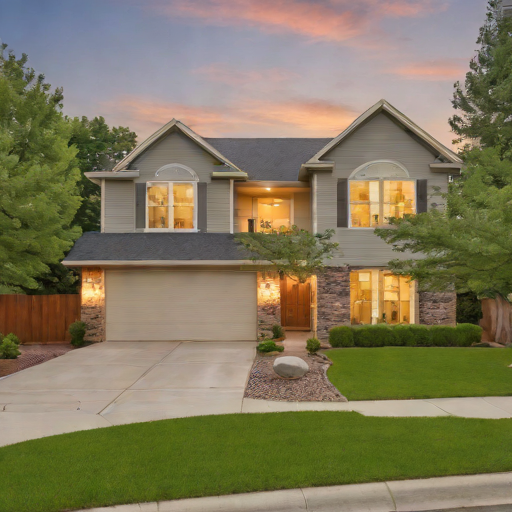

In [14]:
idx = 11
print('Description:', df.iloc[idx]['description'])
print('Neighborhood Description:', df.iloc[idx]['neighborhood_description'])
images[idx] 

Description: Step back in time with this charming 3-bedroom, 2-bathroom home in the historic District neighborhood. The home features original hardwood floors, crown molding, and a cozy fireplace in the living room. The updated kitchen boasts stainless steel appliances and a breakfast nook overlooking the landscaped backyard. Enjoy the convenience of living within walking distance to boutique shops, cafes, and historic landmarks.
Neighborhood Description: District is a picturesque neighborhood known for its historic architecture, cobblestone streets, and quaint shops. Explore the nearby museums, art galleries, and cultural events, or take a leisurely stroll along the riverfront. With easy access to public transportation and bike paths, commuting to work or exploring the city is a breeze.


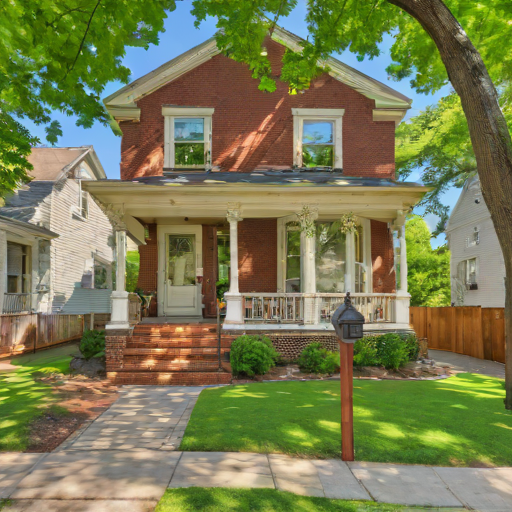

In [15]:
idx = 13
print('Description:', df.iloc[idx]['description'])
print('Neighborhood Description:', df.iloc[idx]['neighborhood_description'])
images[idx] 

Let's save our listing images.

In [16]:
import os
images_dir = 'images'

# Create image directory
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
# Save each image
for i, image in enumerate(images):
    filename = os.path.join(images_dir, str(i) + ".png")
    image.save(filename)

## Multimodal Vector Store and Embeddings
Each listing has an associated text and image information. We collect them first.

In [17]:
import pandas as pd
import os
import PIL

images_dir = 'images'
images = []
text_template = \
"""
Description: {}
Neighborhood Description: {}
Price: {}
Bedrooms: {}
Bathrooms: {}
House Size (sqft): {}
"""

df = pd.read_csv('listings.csv')
image_paths = []
texts = []
ids = [{'id':i} for i in range(len(df.index))]

for i, row in df.iterrows():
    image_file = os.path.join(images_dir, str(i) + ".png")
    images.append(PIL.Image.open(image_file))
    image_paths.append(image_file)
    texts.append(text_template.format(row['description'],
                               row['neighborhood_description'],
                               row['price'],
                               row['bedrooms'],
                               row['bathrooms'],
                               row['house_size']))

We want to map both modalities to the same embedding space so we can compare them semantically. We use the [CLIP Embeddings](https://python.langchain.com/docs/integrations/text_embedding/open_clip).

In [18]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from langchain.vectorstores import Chroma

# Create vector store
db = Chroma(
    collection_name="listings", embedding_function=OpenCLIPEmbeddings()
)

# Add text information
db.add_texts(texts=texts, metadatas = ids)

# Add image information
db.add_images(uris=image_paths, metadatas = ids)

['8b0e196d-d596-11ee-a06e-bc091beacf78',
 '8b0e196e-d596-11ee-809b-bc091beacf78',
 '8b0e196f-d596-11ee-a782-bc091beacf78',
 '8b0e1970-d596-11ee-a110-bc091beacf78',
 '8b0e1971-d596-11ee-af43-bc091beacf78',
 '8b0e1972-d596-11ee-ad32-bc091beacf78',
 '8b0e1973-d596-11ee-a4ab-bc091beacf78',
 '8b0e1974-d596-11ee-b50a-bc091beacf78',
 '8b0e1975-d596-11ee-a1fc-bc091beacf78',
 '8b0e1976-d596-11ee-ac58-bc091beacf78',
 '8b0e1977-d596-11ee-b3d1-bc091beacf78',
 '8b0e1978-d596-11ee-b014-bc091beacf78',
 '8b0e1979-d596-11ee-a87a-bc091beacf78',
 '8b0e197a-d596-11ee-9c2d-bc091beacf78',
 '8b0e197b-d596-11ee-87dd-bc091beacf78']

Expecting 15*2=30 entries in our vector store

In [19]:
res = db.similarity_search("", k=100)

## Buyer's Preference and Semantic Search
We will ask the following questions to the user as guide to get their overall preference. 

In [20]:
QUESTIONS = [   
                "How big do you want your house to be?",
                "What are 3 most important things for you in choosing this property?", 
                "Which amenities would you like?", 
                "Which transportation options are important to you?",
                "How urban do you want your neighborhood to be?",   
            ]

We create a helper function to get the top listings based on the preferences of the user. Since there are two records per listing (one for text and one for image), we will only consider the higher ranking one.

In [21]:
def get_top_listings(preferences: list[str], top_k: int=5) -> list[int]:
    '''
    Returns the ids of the top k listing 
    '''
    top_listings = []
    combined_pref = '\n'.join(preferences)
    
    result = db.similarity_search(combined_pref, k=top_k*2)
    for res in result:
        # skip if it's image r text counterpart is already considered
        # in the ranking
        if res.metadata['id'] in top_listings:
            continue
        top_listings.append(res.metadata['id'])
        
        # already gotten top listings
        if len(top_listings) == top_k:
            break
    return top_listings

For now, we will hardcode the buyer's preference in ANSWERS. 


Description: Step back in time with this charming 3-bedroom, 2-bathroom home in the historic District neighborhood. The home features original hardwood floors, crown molding, and a cozy fireplace in the living room. The updated kitchen boasts stainless steel appliances and a breakfast nook overlooking the landscaped backyard. Enjoy the convenience of living within walking distance to boutique shops, cafes, and historic landmarks.
Neighborhood Description: District is a picturesque neighborhood known for its historic architecture, cobblestone streets, and quaint shops. Explore the nearby museums, art galleries, and cultural events, or take a leisurely stroll along the riverfront. With easy access to public transportation and bike paths, commuting to work or exploring the city is a breeze.
Price: 900000
Bedrooms: 3
Bathrooms: 2
House Size (sqft): 2200



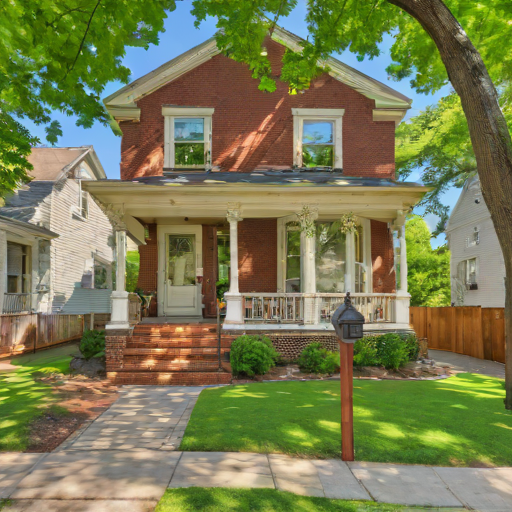

In [22]:
ANSWERS = [
                "A comfortable three-bedroom house with a spacious kitchen and a cozy living room.",
                "A quiet neighborhood, good local schools, and convenient shopping options.",
                "A backyard for gardening, a two-car garage, and a modern, energy-efficient heating system.",
                "Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads.",
                "A balance between suburban tranquility and access to urban amenities like restaurants and theaters."
          ]
res = get_top_listings(ANSWERS)

# check top listing
print(texts[res[0]])
images[res[0]]

We can verify that we can also hit a listing if we have specific preferences not explicitly mentioned in text but present in its corresponding image.


Description: Live in style in this modern 3-bedroom, 2-bathroom loft in the trendy Urban Loft District. The open floor plan features high ceilings, concrete floors, and industrial-chic finishes. The gourmet kitchen is equipped with stainless steel appliances and a breakfast bar. Enjoy the convenience of living within walking distance to hip cafes, art galleries, and boutique shops.
Neighborhood Description: The Urban Loft District is a hip and trendy neighborhood known for its converted industrial spaces, art scene, and creative community. Explore the nearby galleries, attend art events, or dine at the trendy restaurants lining the streets. With easy access to public transportation and bike lanes, commuting to work or exploring the city is a breeze.
Price: 1000000
Bedrooms: 3
Bathrooms: 2
House Size (sqft): 1900



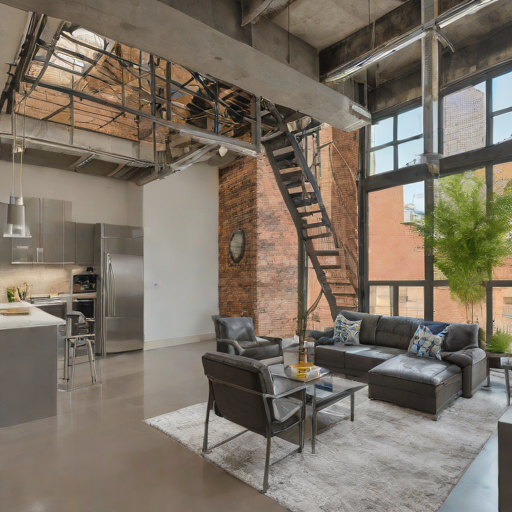

In [23]:
ANSWERS = [
                "A cozy living room.",
                "Huge windows, Furnished with a nice grey sofa for stylish comfort with some lamp shade",
                "",
                "",
                ""
          ]
res = get_top_listings(ANSWERS)

# check top listing
print(texts[res[0]])
images[res[0]]

## Personalization
We want our buyers to have a better experience in our platform by providing personalization of the descriptions of the return results. We will use an LLM again to accomplish this.

In [24]:
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate

model_name = 'gpt-3.5-turbo'
llm = OpenAI(model_name=model_name, temperature=0)

INSTRUCTION = \
"""
Create a short statement for each listing to entice the buyer given their preferences. Try to paraphrase and highlight what the buyer wants.
"""

C:\Users\roysa\.conda\envs\udacity-genai\Lib\site-packages\langchain_community\llms\openai.py:249: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
C:\Users\roysa\.conda\envs\udacity-genai\Lib\site-packages\langchain_community\llms\openai.py:1070: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(


Structure the output of the LLM by defining Pydantic class

In [25]:
from langchain.output_parsers import PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field, NonNegativeInt
from typing import List

class PersonalizedSummary(BaseModel):
    id: int = Field(description="ID of the listing")
    summary: str = Field(description="Generated personalized summaries")

class SummaryCollection(BaseModel):
    summaries: List[PersonalizedSummary] = Field(description="List of generated personalized summaries")
        
parser = PydanticOutputParser(pydantic_object=SummaryCollection)
prompt = PromptTemplate(
    template="{instruction}\nBuyer Preferences:\n{buyer_preferences}\nListings:\n{listings}\n\n{format_instructions}",
    input_variables=["instruction", "buyer_preferences", "listings"],
    partial_variables={"format_instructions": parser.get_format_instructions},
)

In [71]:
cached_summary = {}

def personalize_top_listings(preferences: list[str], top_k: int=5) -> list:
    '''
    Returns a dictionary of personalized description of the listings based
    in user preference
    '''
    # Get the top related listings first
    res = get_top_listings(preferences, top_k)
    top_texts = []
    for idx in res:
        top_texts.append(''.join(['ID:' + str(idx), texts[idx]]))
        
    query = prompt.format(instruction = INSTRUCTION, 
                          buyer_preferences = '\n'.join(preferences),
                          listings = '\n'.join(top_texts))
    output = []
    for summary in parser.parse(llm(query)).summaries:
        output.append((summary.id,summary.summary))
        cached_summary[summary.id] = summary.summary
    return output

Let's see how personalization varies, Notice that the (personalized) summary returned for the top listings (especially 10) highlights features that makes the house feel spacious.

In [72]:
ANSWERS = [
                "A cozy living room.",
                "Huge windows, Furnished with a nice grey sofa for stylish comfort with some lamp shade",
                "",
                "",
                ""
          ]
ans = personalize_top_listings(ANSWERS)
ans

[(10,
  'Live in style in this modern 3-bedroom, 2-bathroom loft in the trendy Urban Loft District. The open floor plan features high ceilings, concrete floors, and industrial-chic finishes. The gourmet kitchen is equipped with stainless steel appliances and a breakfast bar. Enjoy the convenience of living within walking distance to hip cafes, art galleries, and boutique shops.'),
 (5,
  'Live in the heart of the vibrant Arts District in this modern 2-bedroom, 2-bathroom condo. The open floor plan features high ceilings, hardwood floors, and floor-to-ceiling windows offering city views. The gourmet kitchen is equipped with stainless steel appliances and a breakfast bar. Enjoy the convenience of living within walking distance to art galleries, theaters, and trendy restaurants.'),
 (1,
  'Luxury living in the heart of the vibrant Downtown Loft District. This modern 2-bedroom, 2-bathroom loft features high ceilings, exposed brick walls, and floor-to-ceiling windows offering stunning city 

When we modify what is important to us, 10  returned as top results too. Although a bit subtle, this time 10 (and most of the other top listings) mentions and highlights convenience, proximity and access to places. 

In [73]:
ANSWERS = [
                "A cozy living room.",
                "Mobility and traveling is important for me",
                "",
                "",
                ""
          ]
ans = personalize_top_listings(ANSWERS)
ans

[(8,
  'Experience historic charm in this 3-bedroom, 2-bathroom home in the heart of Historic Downtown. Original hardwood floors, exposed brick walls, and a cozy fireplace in the living room. Updated kitchen with stainless steel appliances. Walking distance to historic landmarks, museums, and trendy restaurants.'),
 (10,
  'Live in style in this modern 3-bedroom, 2-bathroom loft in the trendy Urban Loft District. High ceilings, concrete floors, and industrial-chic finishes. Gourmet kitchen with stainless steel appliances. Walking distance to hip cafes, art galleries, and boutique shops.'),
 (3,
  'Step back in time with this charming 3-bedroom, 2-bathroom home in the historic Old Town neighborhood. Original hardwood floors, crown molding, and a cozy fireplace in the living room. Updated kitchen with stainless steel appliances. Walking distance to boutique shops, cafes, and historic landmarks.'),
 (13,
  'Step back in time with this charming 3-bedroom, 2-bathroom home in the historic Di

##  User Interface
We provide a simple graphical interface for the user to provide their input interactively. We use `gradio` to quickly prototype our Machine Learning appication.

In [84]:
import gradio as gr

# Auxiliary event handling methods
def set_sr_tab(request: gr.Request):
    return gr.Tabs(selected=1)

def get_select_index(evt: gr.SelectData):
    listing_id = int(evt._data['value']['image']['orig_name'].split('.')[0])
    return cached_summary[listing_id]

# Fetch personalized listings from user preference
def get_search_result(state, answer0, answer1, answer2, answer3, answer4):
    state = 1
    #ans = personalize_top_listings([answer0, answer1, answer2, answer3, answer4])
    search_results = []
    for id, summary in personalize_top_listings([answer0, answer1, answer2, answer3, answer4]):
        search_results.append((image_paths[id], df.iloc[id]['neighborhood']))
    return [gr.update(selected=state), state, search_results]


# Draw layout of the Graphical User Interface
with gr.Blocks() as demo:
    label = gr.Label("My HomeMatch Application")

    with gr.Tabs() as tabs:
        state = gr.State(0)
        with gr.TabItem("Buyer's Preference", id=0):
            # Create textbox for each question for free-form response
            answers = [] 
            for i in range(len(QUESTIONS)):
                answers.append(gr.Textbox(label=QUESTIONS[i]))
            btn = gr.Button("Submit", scale=0)
    
        # Search results panel
        with gr.TabItem("Search Results", id=1):
            with gr.Row():
                with gr.Column():
                    gallery = gr.Gallery(
                        label="Recommended For You", show_label=True, elem_id="gallery", 
                        columns=[3], rows=[2], object_fit="contain", height="auto", 
                        allow_preview=True)
        
                with gr.Column():
                    personalized_desc = gr.Label(label="Personalized Description")
                    #personalized_desc = gr.Label(label="Original Description")
             
    
    # Set event handling
    btn.click(fn=get_search_result, 
              inputs=[state] + [answers[i] for i in range(len(QUESTIONS))], 
              outputs=[tabs, state, gallery])

    gallery.select(get_select_index, 
                   None, 
                   outputs=personalized_desc)

## Running The Prototype Application
We now run our application to see how it all comes together. Open resulting local URL in your favorite browser if it's small for you or doesn't load correctly in the notebook. 

In [85]:
if __name__ == "__main__":
    demo.launch()

Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.


Enter your preference in the corresponding textboxes inside `Buyer's Preference` tab. Hit Submit once done filling-in. Note that submitting may take several seconds to respond. 

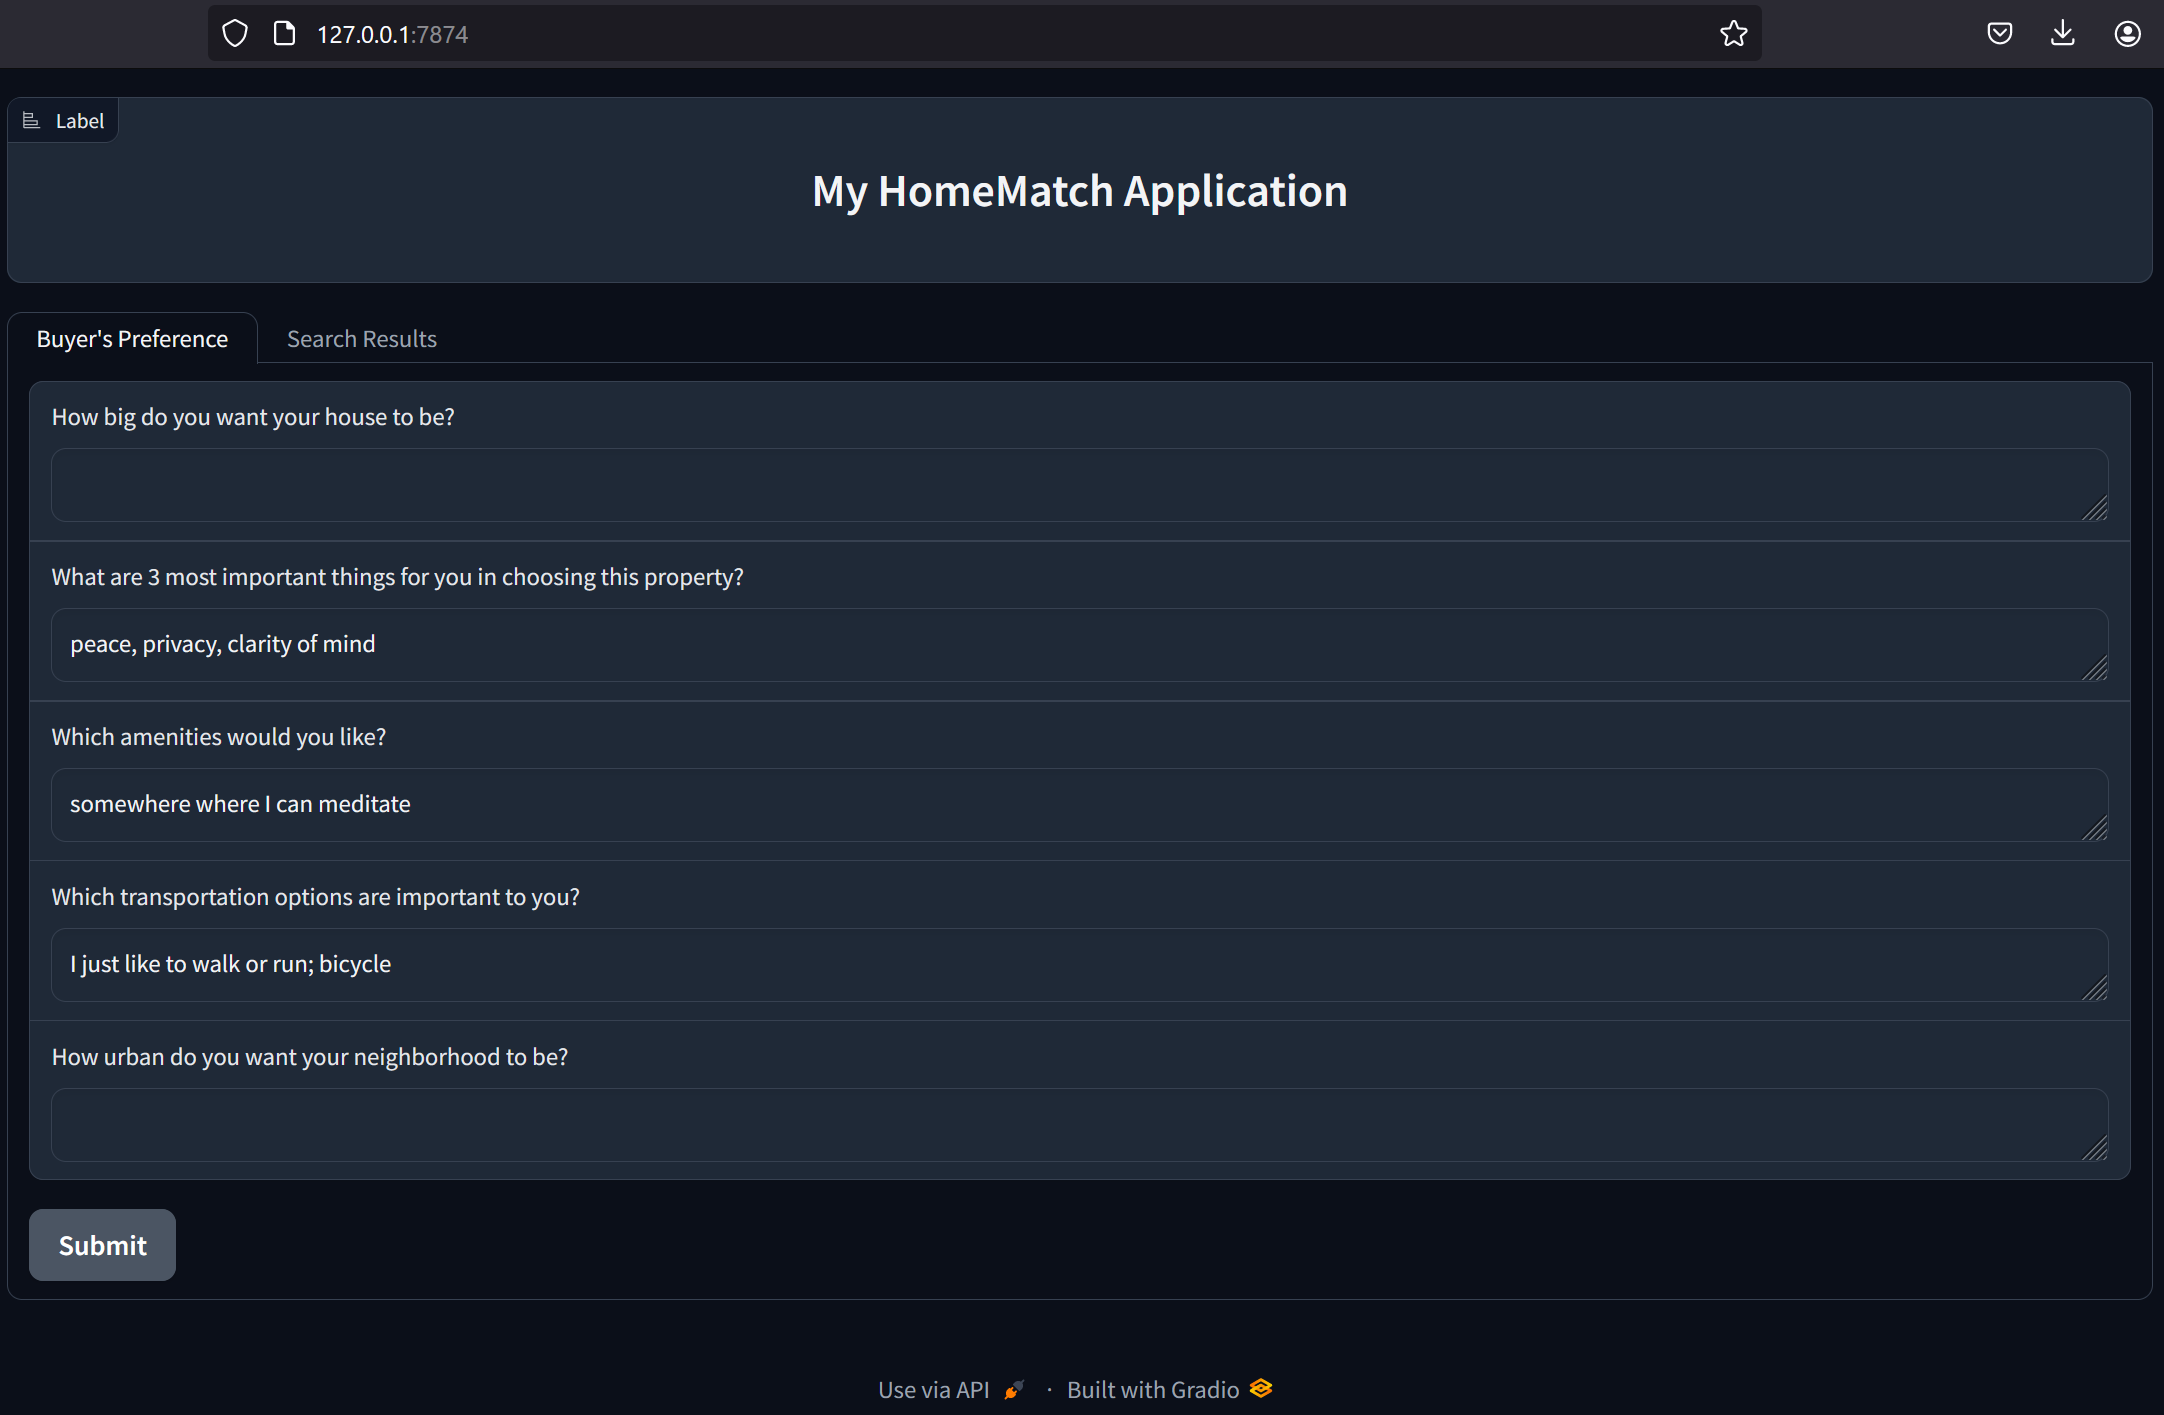

The top five listings will be returned. Hover over the thumbnail of the listing in the gallery and click to view it further.

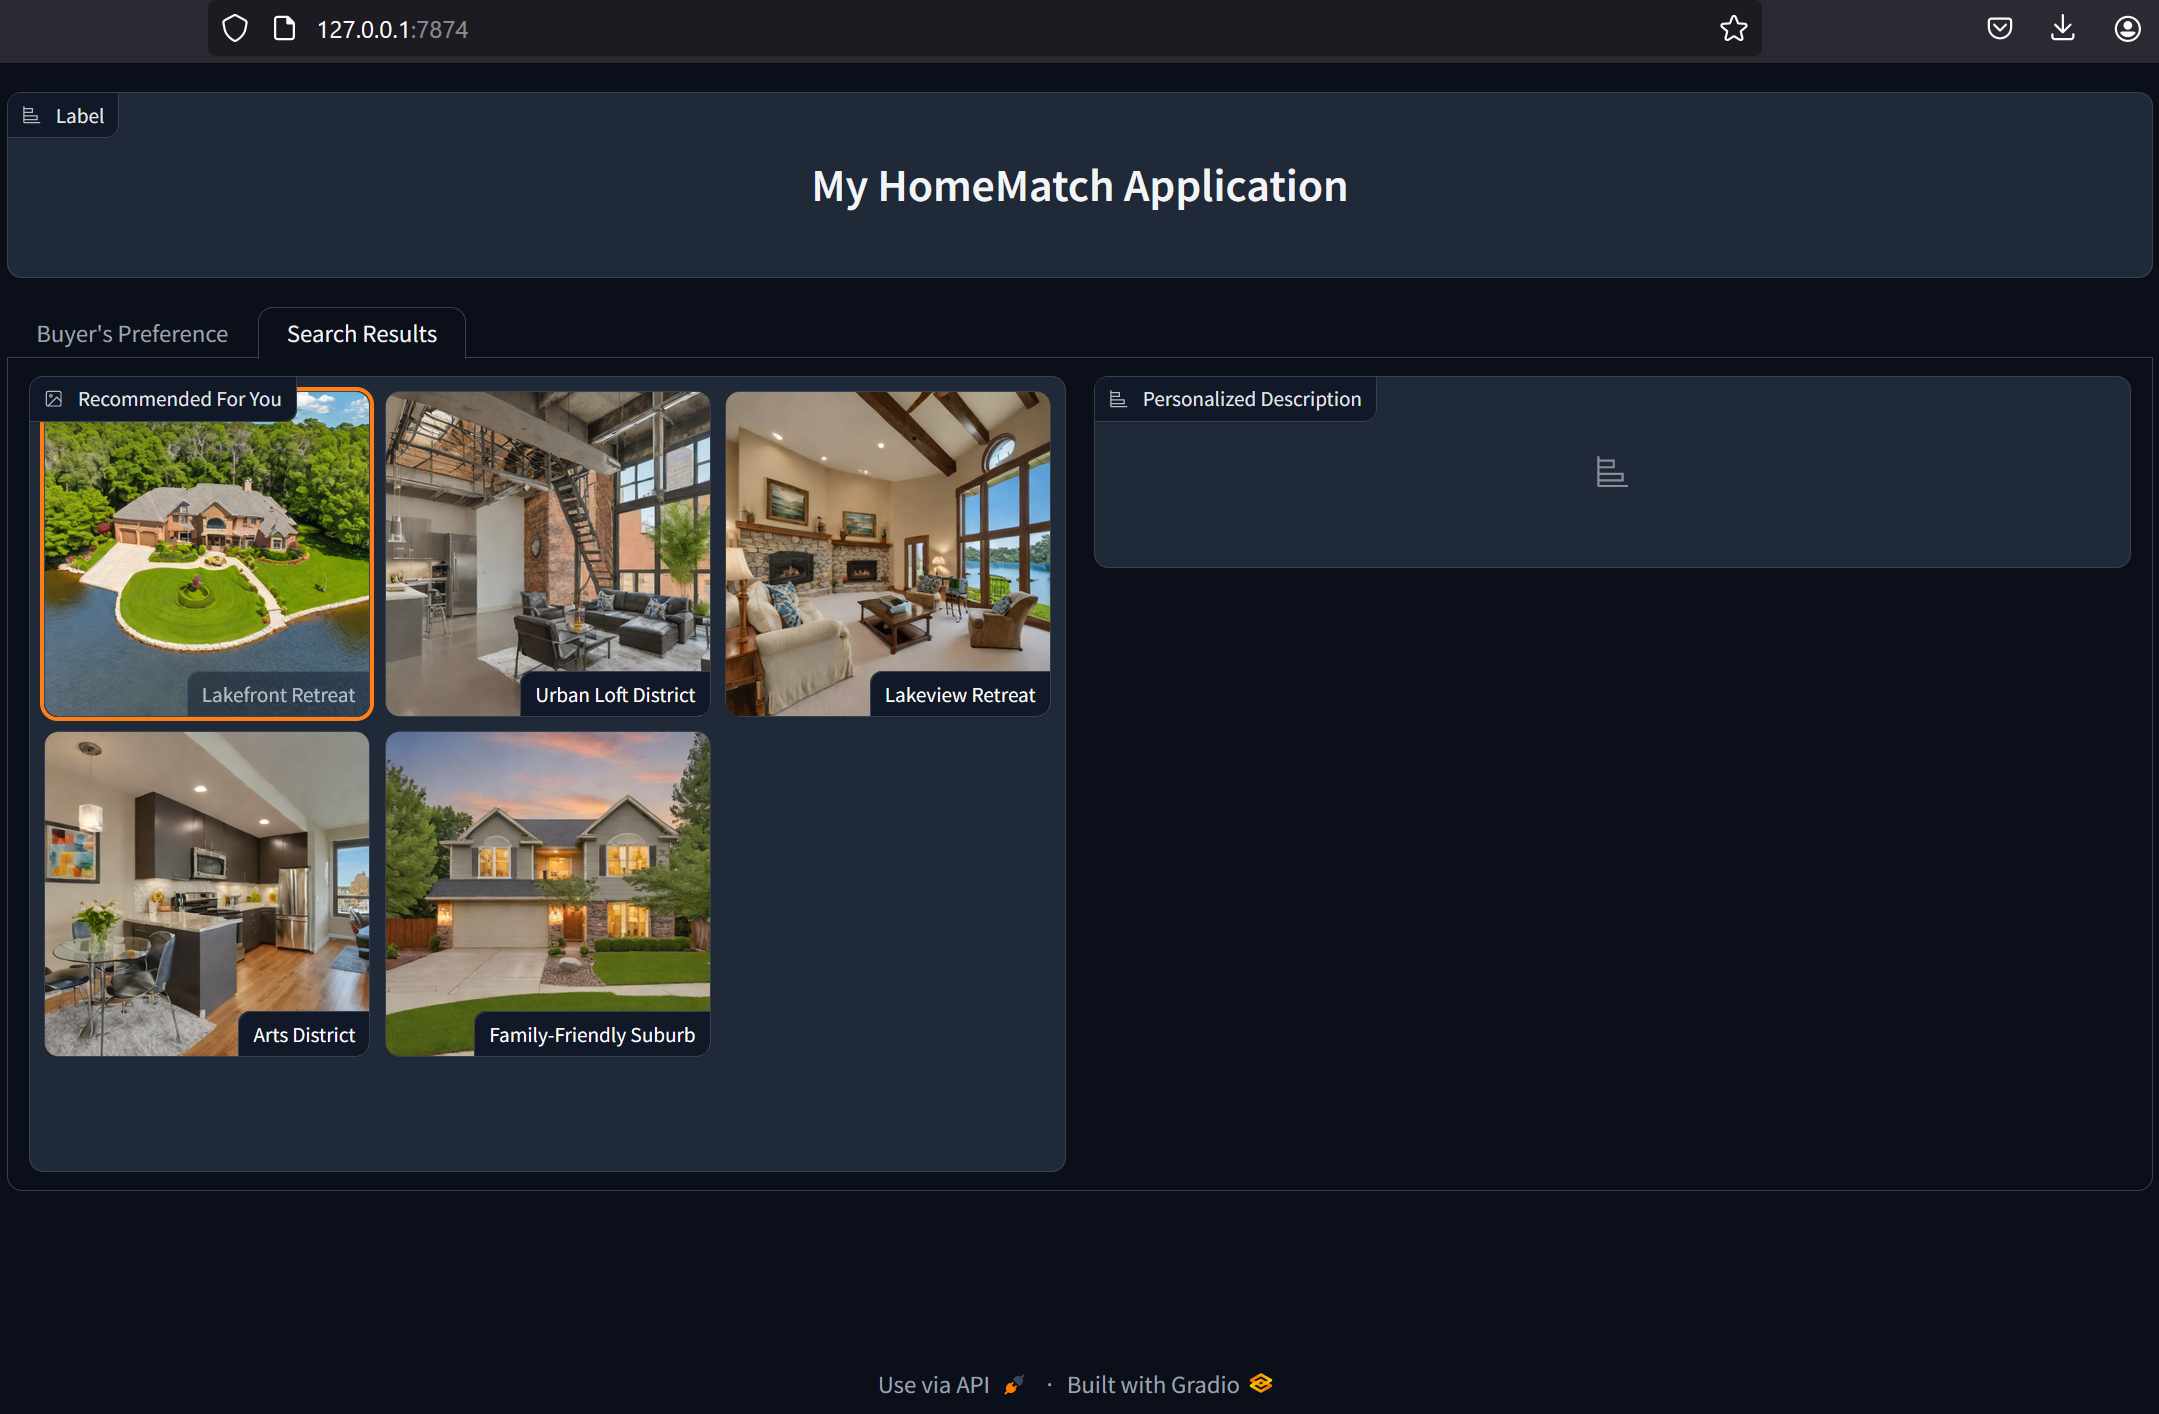

Once a listing is chosen, the personalized description will be displayed. You can also select the other listings. Here are two of my personal results.

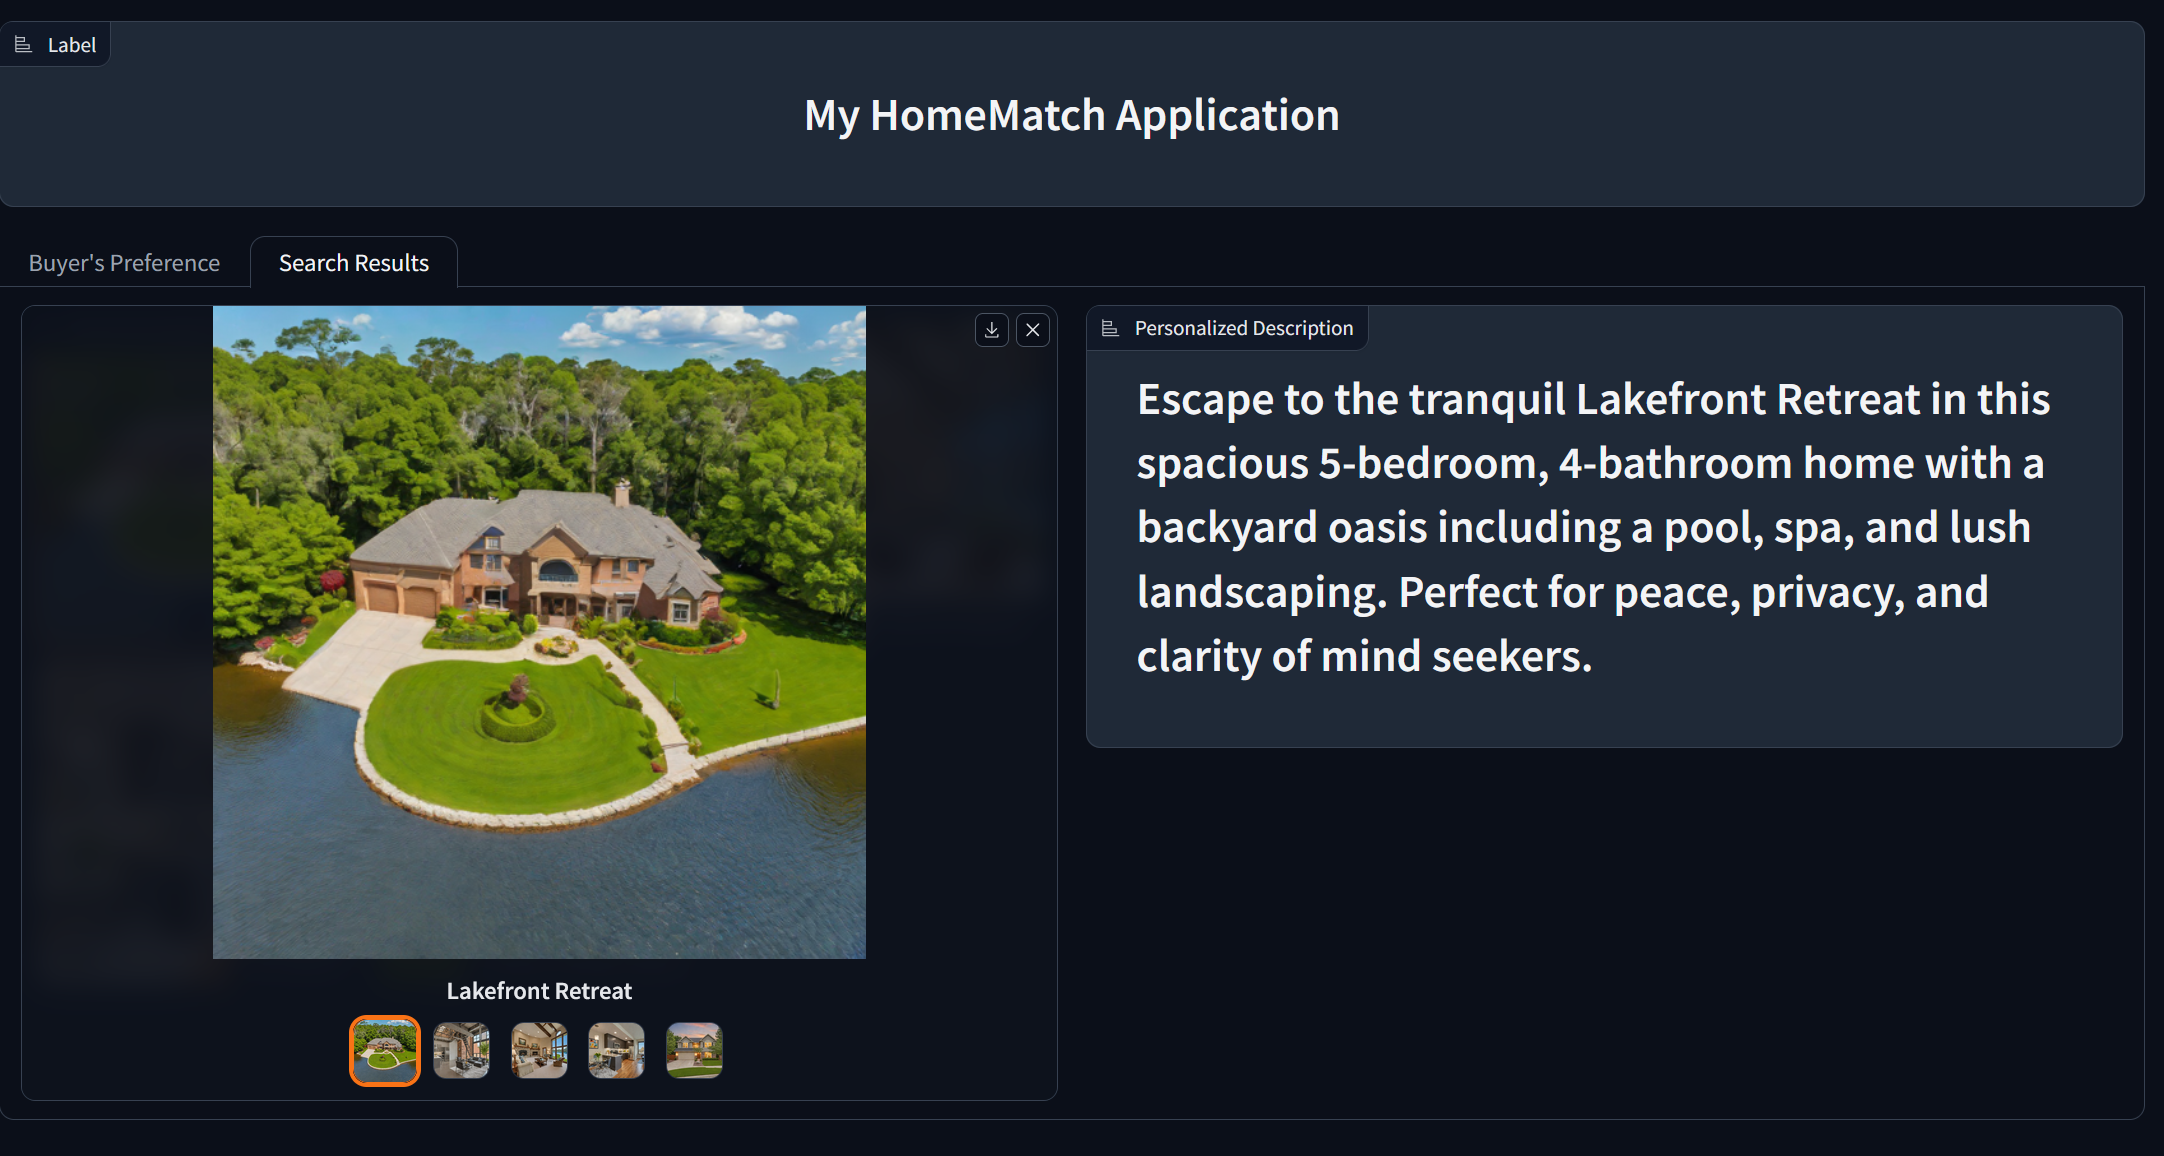
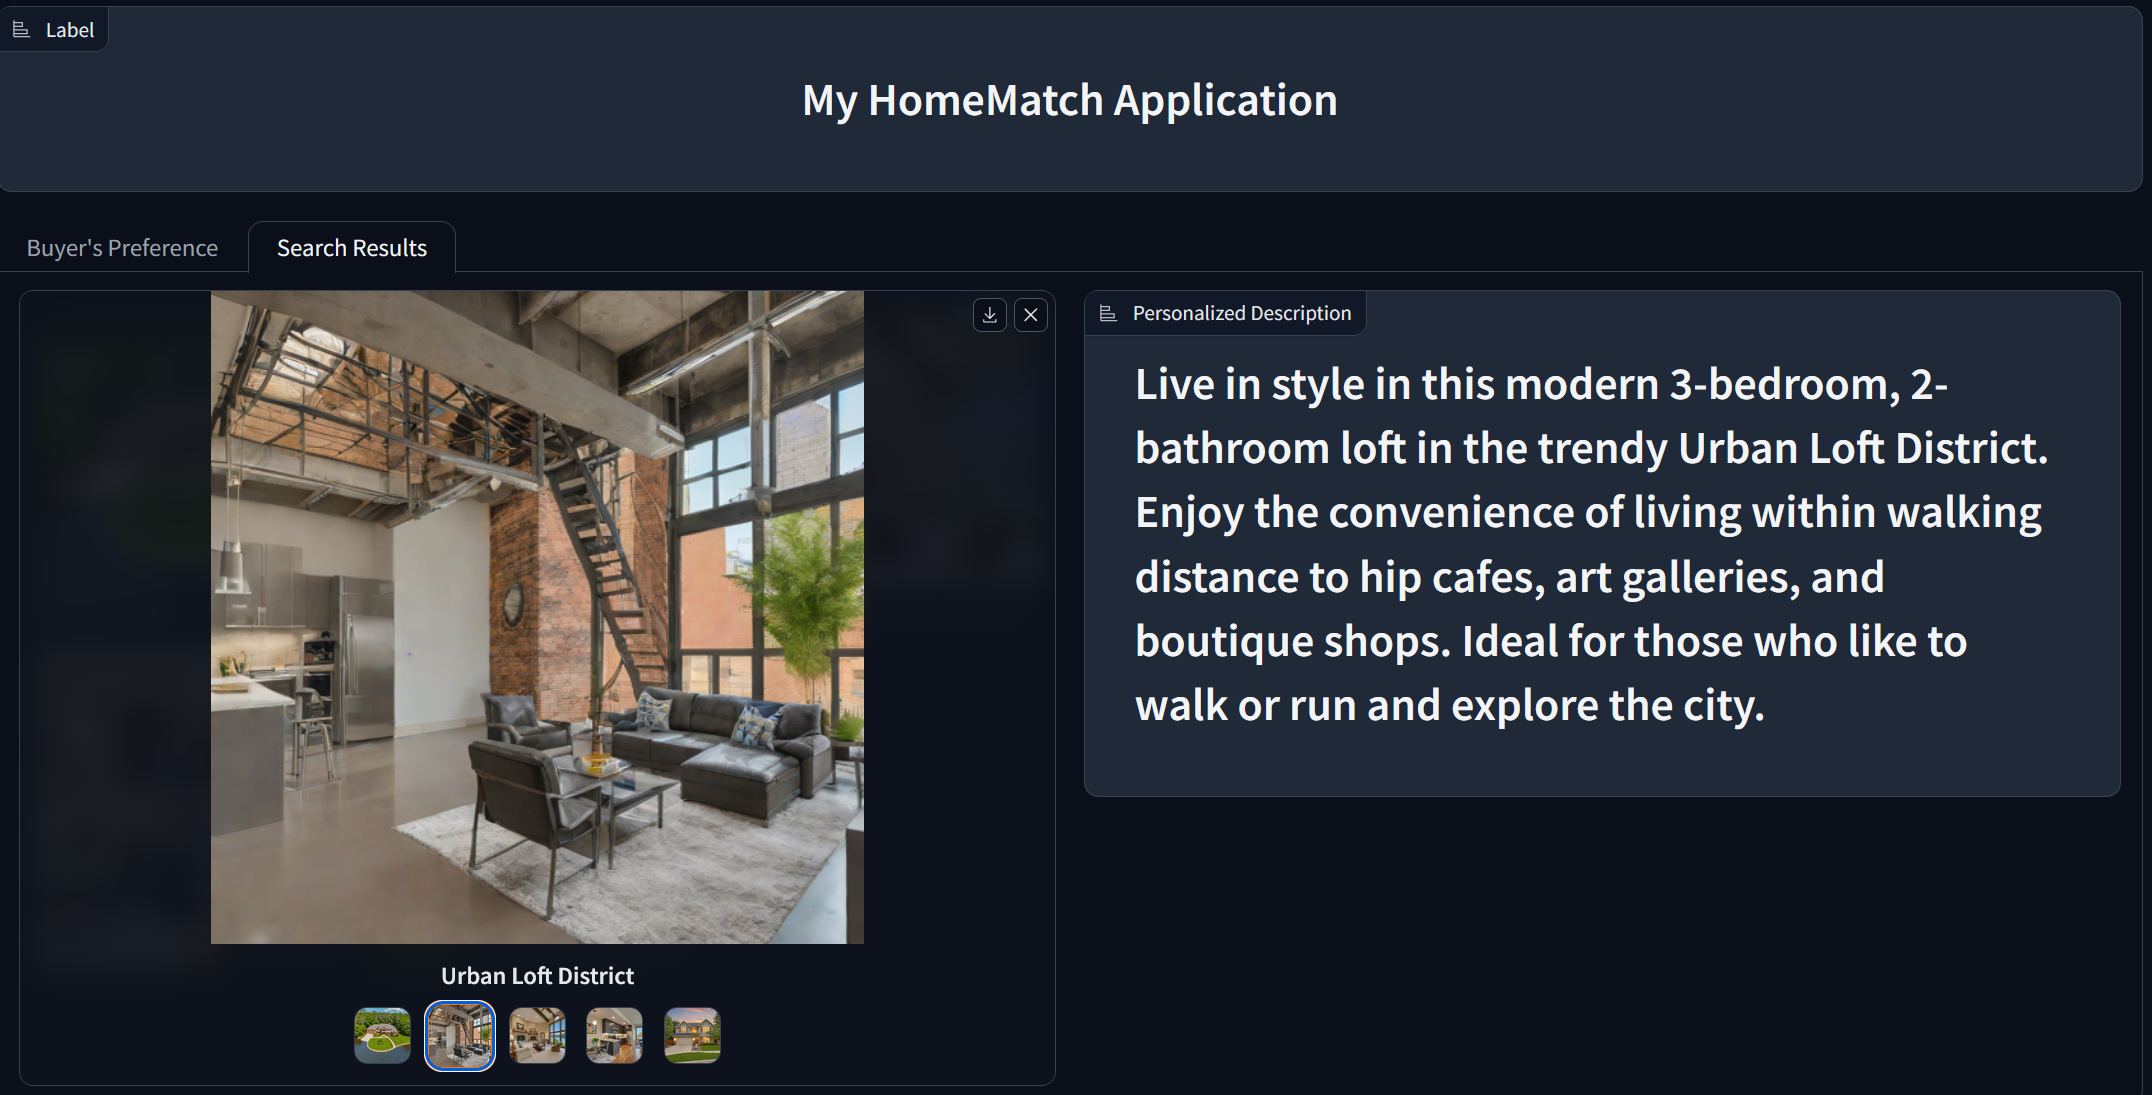


We can go back to the `Buyer's Preference` tab to modify our preferences. The system will try to adapt with our new input.

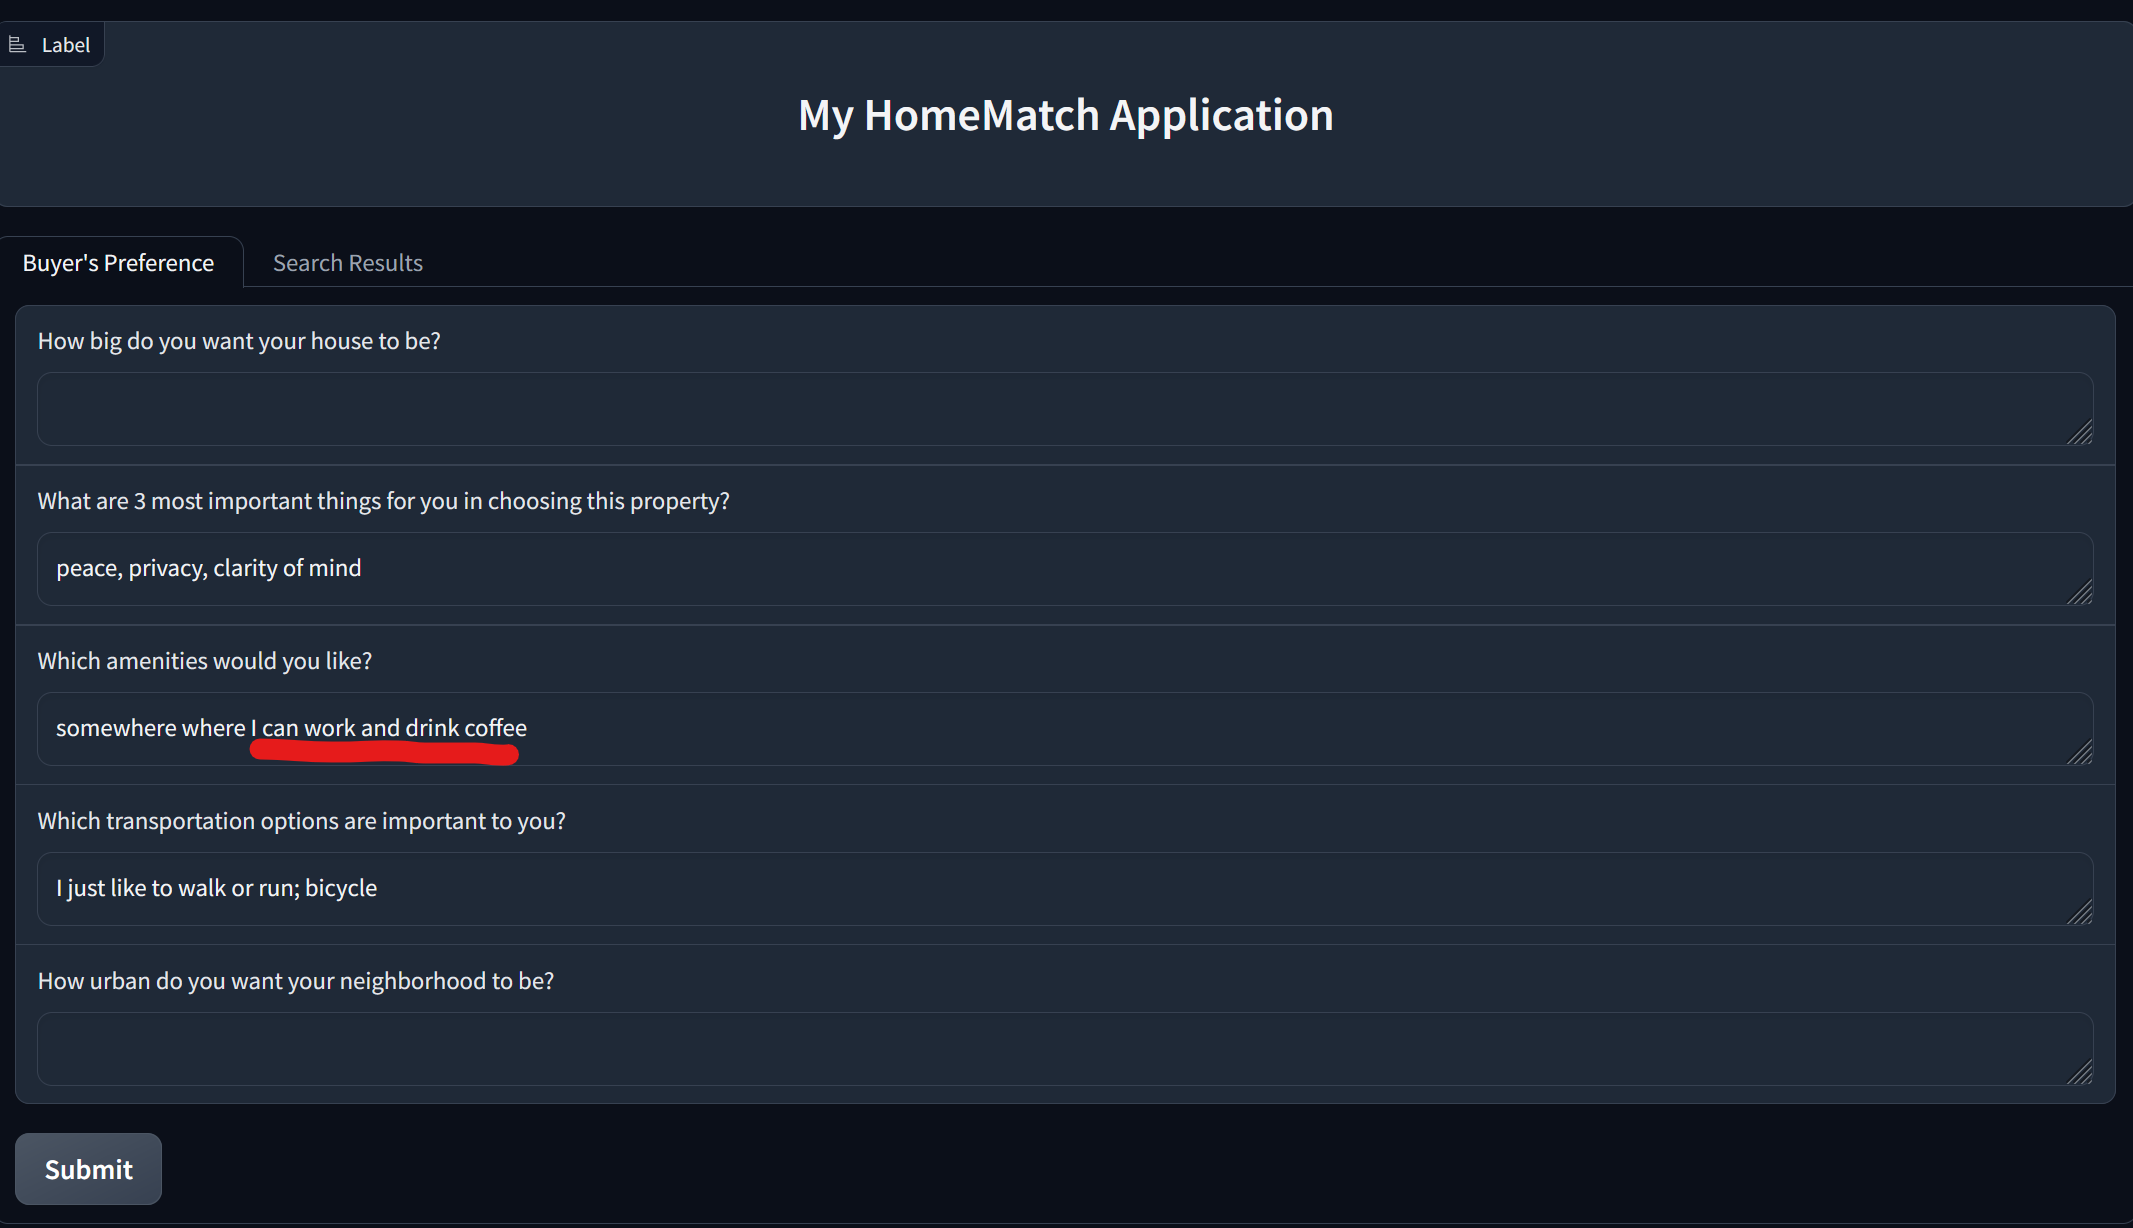
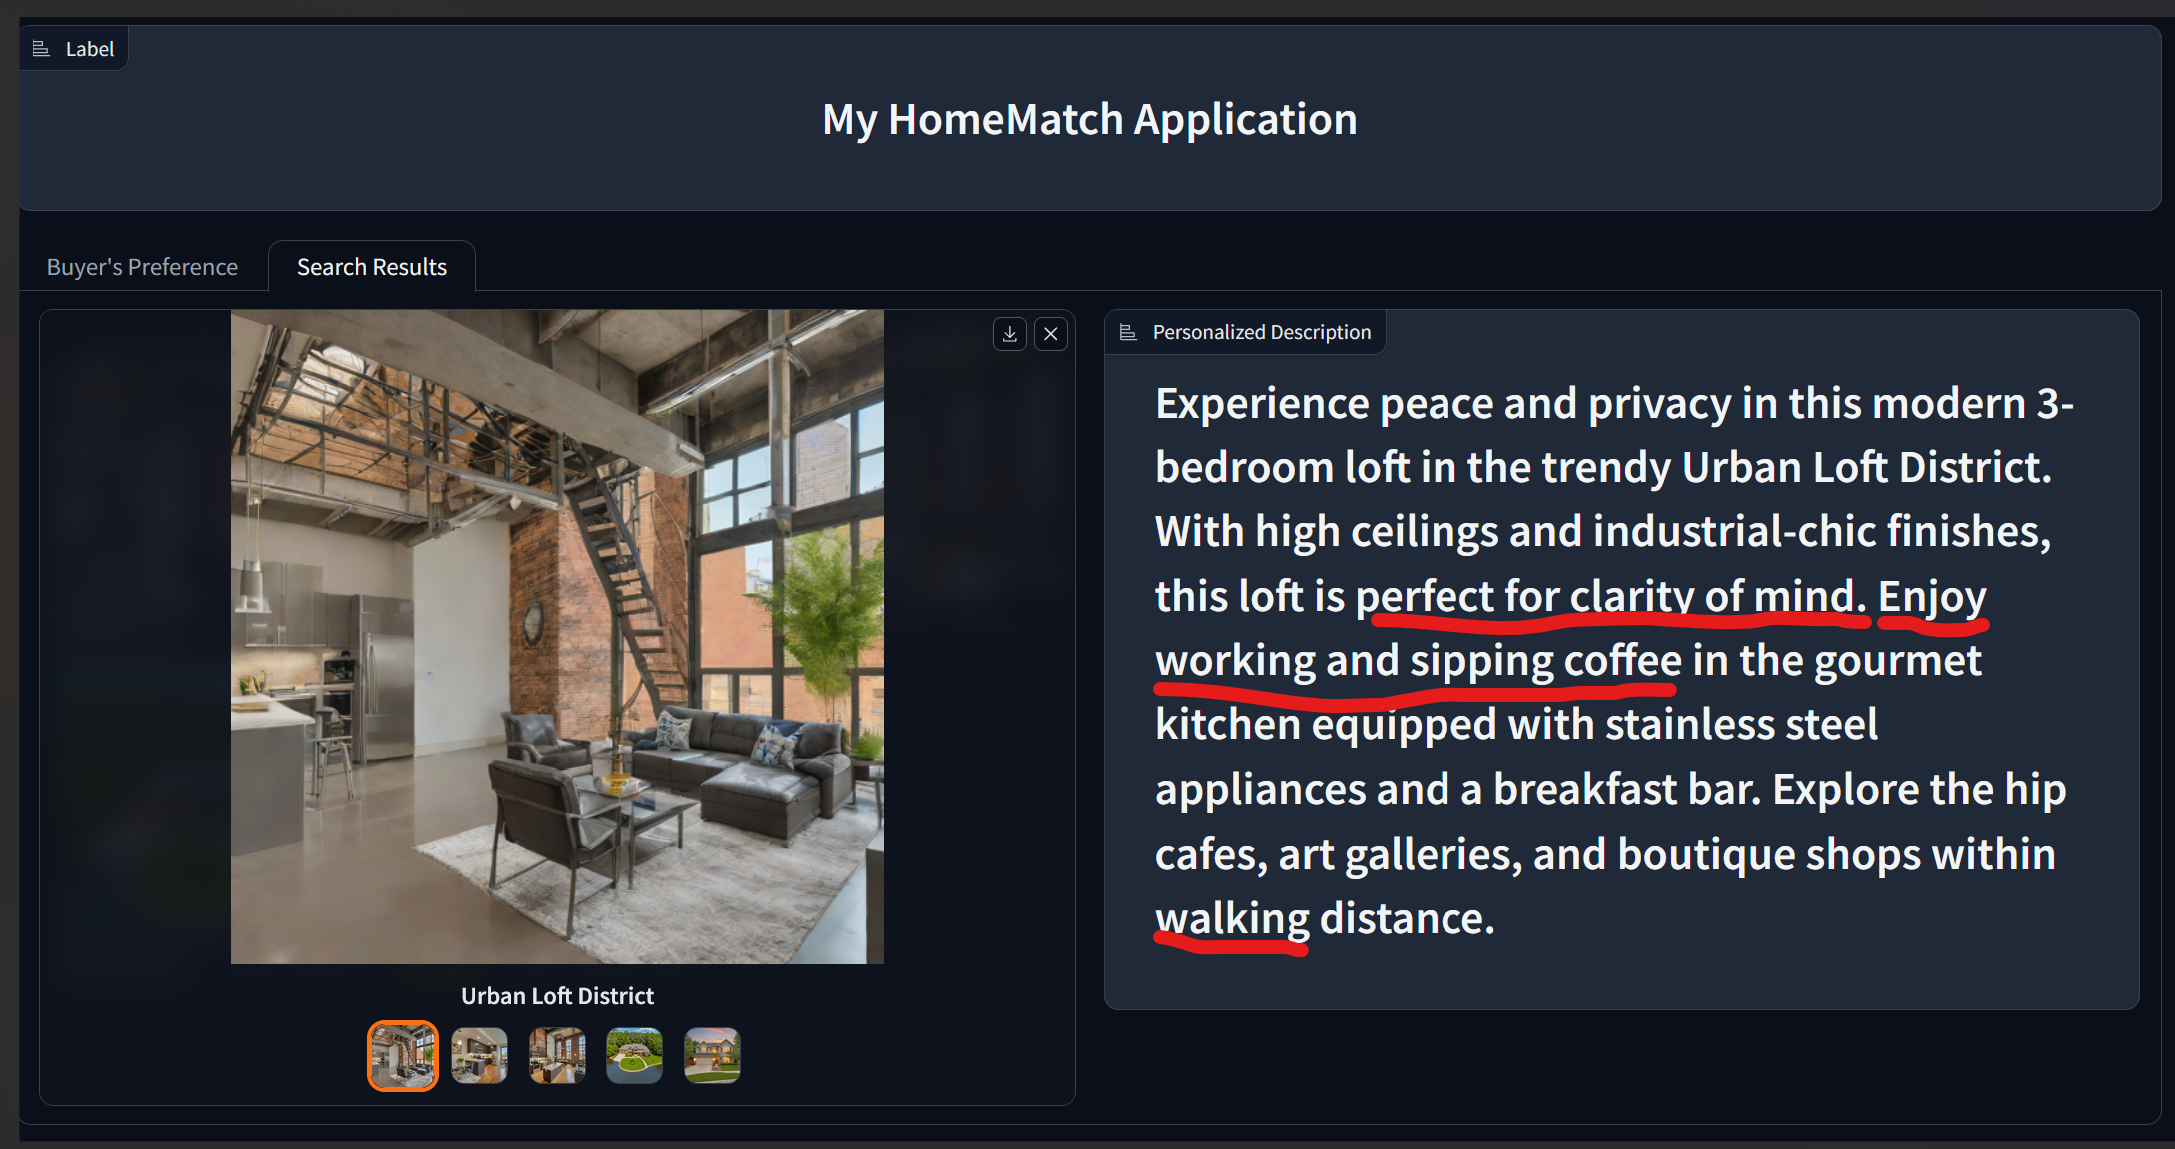